# Classifier based on Sentiment Analysis

In [1]:
# using the gpu
from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'
device

'cuda'

In [2]:
# loading the movie dataset
from google.colab import files
movies = files.upload()

Saving movies.csv to movies.csv


In [3]:
# creating pandas dataframe
import pandas as pd
col_names = ["genre", "split"]
data = pd.read_csv("movies.csv", sep=";", names=col_names)
data = data.sample(frac=1, random_state=42)
data.head()

,genre,split
8826,superhero,"ruling, brother. a throne would suit you ill. ..."
3172,comedy,the hotel. you'd better go straight to the bas...
9221,western,"shooting a man, son. no, it isn't. not in my o..."
718,action,that. we've only got seven minutes. passengers...
3133,comedy,the thames men later became spinal tap and had...


In [4]:
# remove empty lines
data.dropna(inplace=True)

In [5]:
data.genre.unique()

array(['superhero', 'comedy', 'western', 'action', 'fantasy', 'history',
       'adventure', 'sport', 'drama', 'scifi'], dtype=object)

In [6]:
# adding labels to the dataframe
labels = ["action", "adventure", "comedy", "drama", "fantasy", "history", "scifi", "sport", "superhero", "western"]
NUM_LABELS = len(labels)
id2label = {i:l for i,l in enumerate(labels)}
label2id = {l:i for i,l in enumerate(labels)}

In [7]:
label2id

{'action': 0,
 'adventure': 1,
 'comedy': 2,
 'drama': 3,
 'fantasy': 4,
 'history': 5,
 'scifi': 6,
 'sport': 7,
 'superhero': 8,
 'western': 9}

In [8]:
data["labels"] = data.genre.map(lambda x: label2id[x.strip()])

In [9]:
data.head()

,genre,split,labels
8826,superhero,"ruling, brother. a throne would suit you ill. ...",8
3172,comedy,the hotel. you'd better go straight to the bas...,2
9221,western,"shooting a man, son. no, it isn't. not in my o...",9
718,action,that. we've only got seven minutes. passengers...,0
3133,comedy,the thames men later became spinal tap and had...,2


## Alternative: VADER

In [10]:
# install the VADER sentiment analysis library
!pip install vaderSentiment

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 3.2 MB/s eta 0:00:00


In [11]:
# encode the splits using VADER sentiment analysis
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

analyzer = SentimentIntensityAnalyzer()

def analyse_sentiment(text):
  compound_score = analyzer.polarity_scores(text)['compound']
  return compound_score

data['sentiment'] = data['split'].apply(analyse_sentiment)
data.head()

,genre,split,labels,sentiment
8826,superhero,"ruling, brother. a throne would suit you ill. ...",8,-0.5948
3172,comedy,the hotel. you'd better go straight to the bas...,2,0.9224
9221,western,"shooting a man, son. no, it isn't. not in my o...",9,-0.0422
718,action,that. we've only got seven minutes. passengers...,0,-0.9178
3133,comedy,the thames men later became spinal tap and had...,2,0.4276


In [12]:
# split the data into train, val and test sets
SIZE = data.shape[0]

train_sentiment      = list(data.sentiment[:SIZE//2])
val_sentiment        = list(data.sentiment[SIZE//2:(3*SIZE)//4 ])
test_sentiment       = list(data.sentiment[(3*SIZE)//4:])

train_labels         = list(data.labels[:SIZE//2])
val_labels           = list(data.labels[SIZE//2:(3*SIZE)//4])
test_labels          = list(data.labels[(3*SIZE)//4:])

In [13]:
len(train_sentiment), len(val_sentiment), len(test_sentiment)

(5082, 2541, 2541)

In [14]:
# Is the train data balanced?
data[:5082].genre.value_counts()

comedy       606
action       527
adventure    516
fantasy      504
superhero    503
history      498
sport        492
drama        484
western      479
scifi        473
Name: genre, dtype: int64

<Axes: ylabel='genre'>

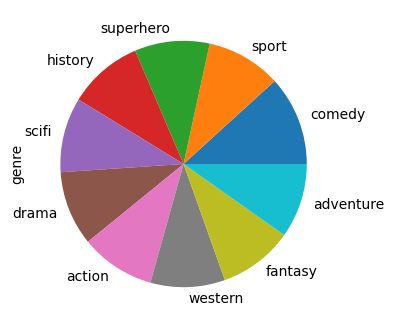

In [15]:
data.genre.value_counts().plot(kind="pie", figsize=(4,4))

# Training a LSTM

In [16]:
import torch
import torch.nn as nn

In [17]:
from torch.utils.data import Dataset
class MyDataset(Dataset):
    def __init__(self, encodings, values):
        self.encodings = encodings
        self.values = values
        #self.encodings = torch.as_tensor(encodings)
        #self.labels = torch.as_tensor(labels)
    def __getitem__(self, idx):
        return torch.as_tensor(self.encodings[idx]).unsqueeze(dim=0), torch.as_tensor(self.values[idx]).unsqueeze(dim=0)
        #return self.encodings[idx], self.labels[idx]
    def __len__(self):
        return len(self.values)

In [18]:
train_dataset = MyDataset(train_sentiment, train_labels)
val_dataset = MyDataset(val_sentiment, val_labels)
test_dataset = MyDataset(test_sentiment, test_labels)

In [23]:
class LSTMModel(nn.Module):
    def __init__(self, input_d, hidden_d, layer_d, output_d):
        super(LSTMModel, self).__init__()

        self.hidden_dim = hidden_d
        self.layer_dim = layer_d

        # LSTM model
        self.lstm = nn.LSTM(input_d, hidden_d, layer_d, batch_first=True)
        # batch_first=True (batch_dim, seq_dim, feature_dim)

        self.fc = nn.Linear(hidden_d, output_d)

    def forward(self, x):
        batch_size, seq_len = x.size(0), x.size(1)

        # Initialize hidden state with zeros
        h0 = torch.zeros(self.layer_dim, batch_size, self.hidden_dim).to(x.device).requires_grad_()
        c0 = torch.zeros(self.layer_dim, batch_size, self.hidden_dim).to(x.device).requires_grad_()

        # Reshape input to (batch_size, seq_len, input_dim)
        x = x.unsqueeze(2)  # Add an extra dimension
        x = x.permute(0, 2, 1)  # Permute dimensions to (batch_size, input_dim, seq_len)

        # Forward pass
        out, (hn, cn) = self.lstm(x, (h0, c0))

        # Select the last time step
        out = self.fc(out[:, -1, :])
        return out

        #batch_size, seq_len = x.size(0), x.size(1)

        # Initialize hidden state with zeros
        #h0 = torch.zeros(self.layer_dim, batch_size, self.hidden_dim).to(x.device).requires_grad_()
        #c0 = torch.zeros(self.layer_dim, batch_size, self.hidden_dim).to(x.device).requires_grad_()

        # Reshape input to (batch_size * seq_len, input_dim)
        #x_reshaped = x.view(batch_size * seq_len, -1)

        # Forward pass
        #out, (hn, cn) = self.lstm(x_reshaped, (h0, c0))

        # Reshape output to (batch_size, seq_len, hidden_dim)
        #out = out.view(batch_size, seq_len, -1)

        # Select the last time step
        #out = self.fc(out[:, -1, :])
        #return out

        #h0 = torch.randn(self.layer_dim, x.size(0), self.hidden_dim).to(x.device)
        #c0 = torch.randn(self.layer_dim, x.size(0), self.hidden_dim).to(x.device)

        #h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_()

        #c0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_()

        #out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        #out, (hn, cn) = self.lstm(x, (h0, c0))

        #out = self.fc(out[:, -1])
        #return out

input_dim = 1
hidden_dim = 16
output_dim = 10
layer_dim = 1

lstm = LSTMModel(input_dim, hidden_dim, layer_dim, output_dim)

In [24]:
from torch.utils.data import DataLoader
train_dl = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=lambda x: x)
dev_dl = DataLoader(val_dataset, batch_size=32, shuffle=False, collate_fn=lambda x: x)

In [25]:
optim = torch.optim.AdamW(lstm.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss(ignore_index=-1)

In [26]:
def acc(logits, y):
    """Compute the accuracy of the predictions against the gold labels, ignoring -1s for pads."""
    preds = logits.argmax(dim=-1)
    mask = y != -1
    return (preds[mask] == y[mask]).float().mean()

for epoch in range(10):
    train_losses = torch.zeros(len(train_dl))
    for i, batch in enumerate(train_dl):
        optim.zero_grad()

        # Extract inputs and labels from the batch
        x = [b[0] for b in batch]
        y = [b[1] for b in batch]

        # Print shapes for debugging
        #print(f"Shapes - x: {[t.shape for t in x]}, y: {[t.shape for t in y]}")

        # Convert the list of tensors to a padded sequence
        x_padded = torch.nn.utils.rnn.pad_sequence(x, batch_first=True)

        # Print the shape of x_padded
        #print(f"Shape of x_padded: {x_padded.shape}")

        # Forward pass
        logits = lstm(x_padded)

        # Flatten logits and labels
        logits_flat = logits.view(-1, logits.shape[-1])
        y_flat = torch.cat(y)

        # Print the shapes of logits_flat and y_flat
        #print(f"Shapes - logits_flat: {logits_flat.shape}, y_flat: {y_flat.shape}")

        # Compute loss
        loss = criterion(logits_flat, y_flat)
        train_losses[i] = loss.item()

        # Backward pass and optimization
        loss.backward()
        optim.step()


        #optim.zero_grad()

        #x = [b[0] for b in batch]
        #x = torch.nn.utils.rnn.pad_sequence([b[0] for b in batch], batch_first=True)
        #y = [b[1] for b in batch]
        #y = torch.nn.utils.rnn.pad_sequence([b[1] for b in batch], batch_first=True, padding_value=-1)
        #spans = torch.nn.utils.rnn.pad_sequence([b[2].t() for b in batch], batch_first=True)

        # logits: (batch_size, seq_len, num_pos_tags)
        #logits = lstm(x, spans)
        #logits = lstm(x)

        # logits: (batch_size*seq_len, num_pos_tags)
        #logits = logits.view(-1, logits.shape[-1])
        #y = y.view(-1)
        #loss = criterion(logits, y)
        #train_losses[i] = loss.item()

        #loss.backward()
        #optim.step()
        print(f"Epoch {epoch} batch {i} loss: {loss.item()}", end="\r", flush=True)

    print(f"Epoch {epoch} loss: {train_losses.mean()}")

    # evaluate on dev set
    with torch.no_grad():
        dev_losses = torch.zeros(len(dev_dl))
        dev_accs = torch.zeros(len(dev_dl))
        for i, batch in enumerate(dev_dl):
            x = torch.nn.utils.rnn.pad_sequence([b[0] for b in batch], batch_first=True)
            y = torch.nn.utils.rnn.pad_sequence([b[1] for b in batch], batch_first=True, padding_value=-1)
            #spans = torch.nn.utils.rnn.pad_sequence([b[2].t() for b in batch], batch_first=True)

            # logits: (batch_size, seq_len, num_pos_tags)
            #logits = pos_tagger(x, spans)
            logits = lstm(x)

            # logits: (batch_size*seq_len, num_pos_tags)
            logits = logits.view(-1, logits.shape[-1])
            y = y.view(-1)
            loss = criterion(logits, y)
            dev_losses[i] = loss.item()
            dev_accs[i] = acc(logits, y)

        print(f"Epoch {epoch} dev loss: {dev_losses.mean()}, dev acc: {dev_accs.mean()}")

Epoch 0 loss: 2.309922218322754
Epoch 0 dev loss: 2.306558132171631, dev acc: 0.09236778318881989
Epoch 1 loss: 2.3003602027893066
Epoch 1 dev loss: 2.2991740703582764, dev acc: 0.11637619882822037
Epoch 2 loss: 2.2943527698516846
Epoch 2 dev loss: 2.294405221939087, dev acc: 0.12379807233810425
Epoch 3 loss: 2.2905075550079346
Epoch 3 dev loss: 2.2921066284179688, dev acc: 0.12575119733810425
Epoch 4 loss: 2.288456916809082
Epoch 4 dev loss: 2.29099702835083, dev acc: 0.12965744733810425
Epoch 5 loss: 2.287135601043701
Epoch 5 dev loss: 2.2905712127685547, dev acc: 0.1304387003183365
Epoch 6 loss: 2.2864017486572266
Epoch 6 dev loss: 2.2901575565338135, dev acc: 0.12947717308998108
Epoch 7 loss: 2.2858994007110596
Epoch 7 dev loss: 2.2899234294891357, dev acc: 0.13025841116905212
Epoch 8 loss: 2.285341262817383
Epoch 8 dev loss: 2.2892894744873047, dev acc: 0.13064904510974884
Epoch 9 loss: 2.2847485542297363
Epoch 9 dev loss: 2.2886030673980713, dev acc: 0.13064904510974884


# Funktioniert nicht

In [ ]:
!pip install -U sentence-transformers

In [ ]:
from sentence_transformers import SentenceTransformer
sentences = ["This is an example sentence", "Each sentence is converted"]

model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')
train_splits_embeddings = model.encode(train_splits)
val_splits_embeddings = model.encode(val_splits)

In [ ]:
from torch.utils.data import Dataset

class MovieGenreDataset(Dataset):
    def __init__(self, text_enc, sentiment):
        self.text_enc  = torch.FloatTensor(text_enc)
        self.sentiment = torch.FloatTensor(sentiment)

    def __len__(self):
        return len(self.text_enc)

    def __getitem__(self, idx):
        return self.text_enc[idx], self.sentiment[idx]

In [ ]:
train_dataset = MovieGenreDataset(train_splits_embeddings, train_sentiments)
dev_dataset = MovieGenreDataset(val_splits_embeddings, val_sentiments)

In [ ]:
from torch.utils.data import DataLoader
train_dl = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=lambda x: x)
dev_dl = DataLoader(dev_dataset, batch_size=32, shuffle=False, collate_fn=lambda x: x)

In [ ]:
optim = torch.optim.AdamW(lstm.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss(ignore_index=-1)

In [ ]:
def acc(logits, y):
    """Compute the accuracy of the predictions against the gold labels, ignoring -1s for pads."""
    preds = logits.argmax(dim=-1)
    mask = y != -1
    return (preds[mask] == y[mask]).float().mean()

for epoch in range(10):
    train_losses = torch.zeros(len(train_dl))
    for i, batch in enumerate(train_dl):

        optim.zero_grad()

        x = torch.nn.utils.rnn.pad_sequence([b[0] for b in batch], batch_first=True)
        y = [b[1] for b in batch]
        #y = torch.nn.utils.rnn.pad_sequence([b[1] for b in batch], batch_first=True, padding_value=-1)
        #spans = torch.nn.utils.rnn.pad_sequence([b[2].t() for b in batch], batch_first=True)

        # logits: (batch_size, seq_len, num_pos_tags)
        #logits = lstm(x, spans)
        logits = lstm(x)

        # logits: (batch_size*seq_len, num_pos_tags)
        logits = logits.view(-1, logits.shape[-1])
        y = y.view(-1)
        loss = criterion(logits, y)
        train_losses[i] = loss.item()

        loss.backward()
        optim.step()
        print(f"Epoch {epoch} batch {i} loss: {loss.item()}", end="\r", flush=True)

    print(f"Epoch {epoch} loss: {train_losses.mean()}")

    # evaluate on dev set
    with torch.no_grad():
        dev_losses = torch.zeros(len(dev_dl))
        dev_accs = torch.zeros(len(dev_dl))
        for i, batch in enumerate(dev_dl):
            x = torch.nn.utils.rnn.pad_sequence([b[0] for b in batch], batch_first=True)
            y = torch.nn.utils.rnn.pad_sequence([b[1] for b in batch], batch_first=True, padding_value=-1)
            #spans = torch.nn.utils.rnn.pad_sequence([b[2].t() for b in batch], batch_first=True)

            # logits: (batch_size, seq_len, num_pos_tags)
            #logits = pos_tagger(x, spans)
            logits = lstm(x)

            # logits: (batch_size*seq_len, num_pos_tags)
            logits = logits.view(-1, logits.shape[-1])
            y = y.view(-1)
            loss = criterion(logits, y)
            dev_losses[i] = loss.item()
            dev_accs[i] = acc(logits, y)

        print(f"Epoch {epoch} dev loss: {dev_losses.mean()}, dev acc: {dev_accs.mean()}")

RuntimeError: ignored

In [ ]:
loss_function = nn.NLLLoss()

# See what the scores are before training
# Note that element i,j of the output is the score for tag j for word i.
# Here we don't need to train, so the code is wrapped in torch.no_grad()
with torch.no_grad():
    inputs = train_splits_embeddings[:]
    tag_scores = model(inputs)
    print(tag_scores)

for epoch in range(3):  # again, normally you would NOT do 300 epochs, it is toy data
    for sentence, tags in train_splits_embeddings:
        # Step 1. Remember that Pytorch accumulates gradients.
        # We need to clear them out before each instance
        model.zero_grad()

        # Step 2. Get our inputs ready for the network, that is, turn them into
        # Tensors of word indices.
        sentence_in = train_splits_embeddings
        targets = train_sentiments

        # Step 3. Run our forward pass.
        tag_scores = model(sentence_in)

        # Step 4. Compute the loss, gradients, and update the parameters by
        #  calling optimizer.step()
        loss = loss_function(tag_scores, targets)
        loss.backward()
        optimizer.step()

# See what the scores are after training
with torch.no_grad():
    inputs = train_splits_embeddings
    tag_scores = model(inputs)

    # The sentence is "the dog ate the apple".  i,j corresponds to score for tag j
    # for word i. The predicted tag is the maximum scoring tag.
    # Here, we can see the predicted sequence below is 0 1 2 0 1
    # since 0 is index of the maximum value of row 1,
    # 1 is the index of maximum value of row 2, etc.
    # Which is DET NOUN VERB DET NOUN, the correct sequence!
    print(tag_scores)

IndexError: ignored

# Funktioniert auch nicht

In [ ]:
# define a new class for POS tagging
import torch.nn as nn

class MovieGenreLSTM(nn.Module):

    def __init__(self, char_lm, num_pos_tags, word_lstm_out_dim=64):
        super().__init__()

        # copy the embedding and lstm layers from the language model
        self.embedding = char_lm.embedding
        self.lstm = char_lm.lstm

        # add a bidirectional lstm layer
        self.bi_lstm = nn.LSTM(
            char_lm.lstm.hidden_size,
            word_lstm_out_dim,
            num_layers=1,
            bidirectional=True)

        # a 2-layer MLP to predict the POS tag
        self.pos_head = nn.Sequential(
            nn.Linear(word_lstm_out_dim*4, word_lstm_out_dim),
            nn.ReLU(),
            nn.Linear(word_lstm_out_dim, num_pos_tags)
        )

    def forward(self, x, spans):

        # x: (batch_size, seq_len)
        # embs: (batch_size, seq_len, embedding_dim)
        embs = self.embedding(x)

        # lstm_out: (batch_size, seq_len, hidden_dim)
        lstm_out, _ = self.lstm(embs)

        # bi_char_embs: (batch_size, seq_len, 2*word_lstm_out_dim)
        bi_char_embs, _ = self.bi_lstm(lstm_out)

        # cut the spans tensor in starts and ends
        # starts, ends: (batch_size, seq_len)
        starts = spans[:, :, 0]
        ends = spans[:, :, 1]

        # gather the char embs of all the first and last chars
        # first_char_embs, last_char_embs: (batch_size, seq_len, 2*word_lstm_out_dim)
        first_char_embs = torch.zeros(starts.shape[0], starts.shape[1], bi_char_embs.shape[2])
        last_char_embs = torch.zeros(starts.shape[0], starts.shape[1], bi_char_embs.shape[2])
        for i in range(starts.shape[0]):
            first_char_embs[i] = bi_char_embs[i, starts[i]]
            last_char_embs[i] = bi_char_embs[i, ends[i]-1]

        # concatenate the first and last char embs
        # first_last_char_embs: (batch_size, seq_len, 4*word_lstm_out_dim)
        first_last_char_embs = torch.cat([first_char_embs, last_char_embs], dim=-1)

        # logits: (batch_size, seq_len, num_pos_tags)
        logits = self.pos_head(first_last_char_embs)
        return logits

In [ ]:
pos_tagger = MovieGenreLSTM(model, num_pos_tags=10)
pos_tagger

AttributeError: ignored

## RoBERTa-base

In [ ]:
# import cardiffnlp/twitter-roberta-base-sentiment model from huggingface
from transformers import AutoModelForSequenceClassification
from transformers import TFAutoModelForSequenceClassification
from transformers import AutoTokenizer
import numpy as np
from scipy.special import softmax
import csv
import urllib.request

task='sentiment'
MODEL = f"cardiffnlp/twitter-roberta-base-{task}"

tokenizer = AutoTokenizer.from_pretrained(MODEL)

# download label mapping
labels=[]
mapping_link = f"https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/{task}/mapping.txt"
with urllib.request.urlopen(mapping_link) as f:
    html = f.read().decode('utf-8').split("\n")
    csvreader = csv.reader(html, delimiter='\t')
labels = [row[1] for row in csvreader if len(row) > 1]

# PT
model = AutoModelForSequenceClassification.from_pretrained(MODEL)
model.save_pretrained(MODEL)

config.json:   0%|          | 0.00/747 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/499M [00:00<?, ?B/s]

In [ ]:
# define sentiment analyser for the encoding
def analyse_sentiment(text):
  encoded_input = tokenizer(text, return_tensors='pt')
  output = model(**encoded_input)
  scores = output[0][0].detach().numpy()
  scores = softmax(scores)

  ranking = np.argsort(scores)
  ranking = ranking[::-1]
  sentiment_label = labels[ranking[0]]
  sentiment_score = scores[ranking[0]]

  if sentiment_label == "negative":
    return 0.0 + sentiment_score
  elif sentiment_label == "neutral":
    return 1.0 + sentiment_score
  elif sentiment_label == "positive":
    return 2.0 + sentiment_score

#Examples:
#print(analyse_sentiment("shooting a man, son. no, it isn't. not in my o"))
#print(analyse_sentiment("the thames men later became spinal tap and had"))

In [ ]:
x = data[0:10]
x['sentiment'] = x['split'].apply(analyse_sentiment)
x.head(10)

<ipython-input-15-2e9af0255940>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x['sentiment'] = x['split'].apply(analyse_sentiment)


,genre,split,sentiment
8826,superhero,"ruling, brother. a throne would suit you ill. ...",1.477646
3172,comedy,the hotel. you'd better go straight to the bas...,1.426317
9221,western,"shooting a man, son. no, it isn't. not in my o...",0.714768
718,action,that. we've only got seven minutes. passengers...,0.591064
3133,comedy,the thames men later became spinal tap and had...,1.485931
9382,western,wolves is very quiet these days. is his heart ...,2.503856
4375,fantasy,they stretch like mad. - let's go put him in t...,1.640711
5856,history,him room. clear. clear. move aside. the 96th.....,2.604879
1817,adventure,"you get ten percent, - and that's me being gen...",0.498994
582,action,ask. then you have to find me. you're on. i'm ...,2.433458


In [ ]:
data['sentiment'][0:10] = data['split'].apply(analyse_sentiment)
data.head(10)

KeyboardInterrupt: ignored

In [ ]:
data["sentiment"] = 0

for index, row in data.iterrows():
    data.at[index, "sentiment"] = analyse_sentiment(row["split"])

data.head()

In [ ]:
data["sentiment"] = 0

for i in range(len(data["split"])):
  data["sentiment"][int(i)] = analyse_sentiment(data["split"][int(i)])

data.head()

## DistilRoBERTa (7 emotions)

In [ ]:
from transformers import pipeline
classifier = pipeline("text-classification", model="j-hartmann/emotion-english-distilroberta-base", return_all_scores=False)

/usr/local/lib/python3.10/dist-packages/transformers/pipelines/text_classification.py:105: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


[{'label': 'joy', 'score': 0.9771687984466553}]

In [ ]:
def analyse_sentiment_dist(text):
  result = classifier(text)
  label = result[0]["label"]
  score = result[0]["score"]

  match label:
    case "anger":
      return 0.0 + score
    case "disgust":
      return 1.0 + score
    case "fear":
      return 2.0 + score
    case "joy":
      return 3.0 + score
    case "neutral":
      return 4.0 + score
    case "sadness":
      return 5.0 + score
    case "surprise":
      return 6.0 + score

3.983601748943329 2.994018077850342 1.9865193963050842 0.9918979406356812


In [ ]:
x = data[0:10]
x['sentiment'] = x['split'].apply(analyse_sentiment_dist)
x.head(10)

<ipython-input-25-a2d46218a580>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x['sentiment'] = x['split'].apply(analyse_sentiment_dist)


,genre,split,sentiment
8826,superhero,"ruling, brother. a throne would suit you ill. ...",0.810633
3172,comedy,the hotel. you'd better go straight to the bas...,6.408363
9221,western,"shooting a man, son. no, it isn't. not in my o...",2.964040
718,action,that. we've only got seven minutes. passengers...,0.937774
3133,comedy,the thames men later became spinal tap and had...,4.447267
9382,western,wolves is very quiet these days. is his heart ...,3.983623
4375,fantasy,they stretch like mad. - let's go put him in t...,4.340572
5856,history,him room. clear. clear. move aside. the 96th.....,4.864731
1817,adventure,"you get ten percent, - and that's me being gen...",6.840303
582,action,ask. then you have to find me. you're on. i'm ...,2.535080


In [ ]:
data['sentiment'] = data['split'].apply(analyse_sentiment_dist)
data.head(10)

Token indices sequence length is longer than the specified maximum sequence length for this model (748 > 512). Running this sequence through the model will result in indexing errors


RuntimeError: ignored